필요한 패키지를 가져옵니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.datasets import fashion_mnist

패션아이템 이미지 데이터셋을 불러옵니다. 

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print('x_train shape : ' + str(x_train.shape))
print('y_train shape : ' + str(y_train.shape))
print('x_test shape : ' + str(x_test.shape))
print('y_test shape : ' + str(y_test.shape))

4431872/4422102 [==============================] - 0s 0us/step
x_train shape : (60000, 28, 28)
y_train shape : (60000,)
x_test shape : (10000, 28, 28)
y_test shape : (10000,)


테스트할 샘플 하나를 살펴봅니다.

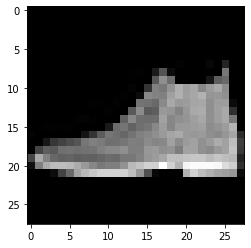

In [3]:
import matplotlib.pyplot as plt

plt.imshow(x_test[0], cmap='gray')

인공지능 모델이 이 이미지를 입력받았을 때, 해당하는 숫자를 출력할 수 있도록 만드는 것이 목표입니다. 우리는 y_test 라벨값도 가지고 있어서 바로 확인은 할 수 있으나, 모델 학습 시에는 사용이 되지 않으며, 시험 평가할 때만 사용됩니다.

In [4]:
print(y_test[0])

9


패션아이템 이미지와 라벨의 숫자가 의미하는 아이템 이름과 함께 같이 가시화 시킵니다.

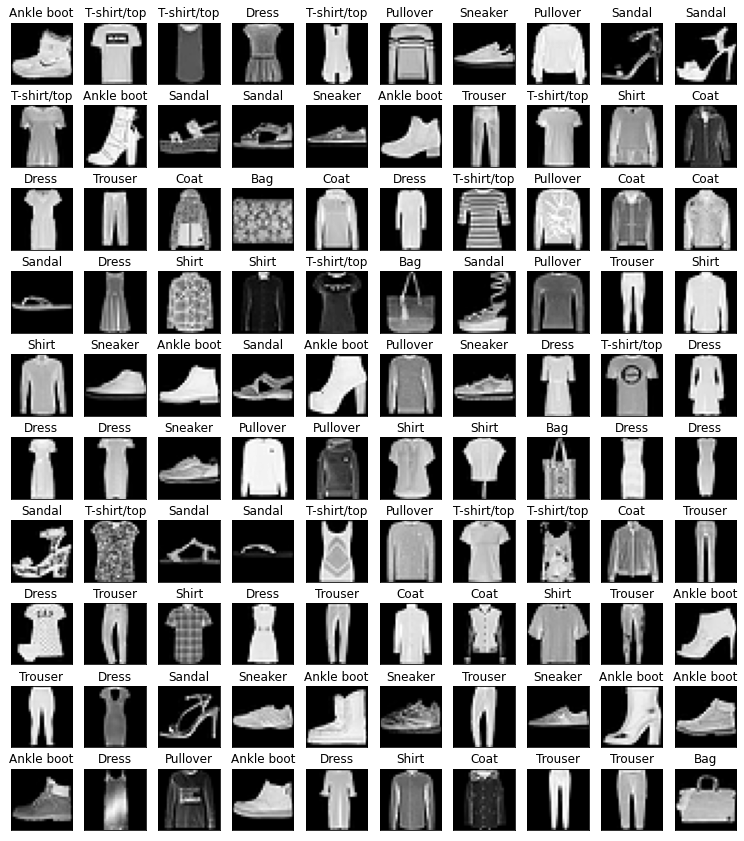

In [5]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(13, 15), 
                         subplot_kw={'xticks': [], 'yticks': []})

labels = ['T-shirt/top',
          'Trouser',
          'Pullover',
          'Dress',
          'Coat',
          'Sandal',
          'Shirt',
          'Sneaker',
          'Bag',
          'Ankle boot']

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], cmap = 'gray')
    title = labels[y_train[i]]
    ax.set_title(title)

plt.show()

모델 학습에 용이하도록 다음과 같이 데이터 전처리를 수행합니다.

*   데이터 전처리
    * 3차원(샘플수, 세로, 가로)를 4차원(샘플수, 세로, 가로, 채널)으로 변경
    * 정수를 실수로 변경
    * 0 ~ 255 사이의 수치를 0.0 ~ 1.0 사이로 정규화 수행
*   라벨 전처리
    * 0 ~ 9 라벨에 대한 원핫인코딩 수행 



In [6]:
x_train = x_train.reshape(60000, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(10000, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

모델은 다음과 같이 구성하였습니다.

* 입력: 3차원 벡터 (세로 28, 가로 28, 채널 1)
* 출력: 10개 벡터
* 출력층의 활성화 함수: 소프트맥스
* 손실함수: categorical_crossentropy
* 최적화기: adam
* 평가 메트릭: accuracy

컨볼루션 신경망을 구성하기 위해, 컨볼루션 레이어, 맥스풀링 레이어, 플래튼 레이어를 사용하였습니다.


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1), activation='relu'),
    Conv2D(32, (3, 3), padding='same', activation='relu'), 
    Conv2D(32, (3, 3), padding='same', activation='relu'), 
    Conv2D(32, (3, 3), padding='same', activation='relu'), 
    MaxPooling2D(pool_size=(2, 2)), 
    Conv2D(128, (3, 3), padding='same', activation='relu'), 
    Conv2D(64, (3, 3), padding='same', activation='relu'), 
    MaxPooling2D(pool_size=(2, 2)), 
    Conv2D(64, (3, 3), padding='same', activation='relu'), 
    Conv2D(64, (3, 3), padding='same', activation='relu'), 
    MaxPooling2D(pool_size=(2, 2)),     
    Flatten(), 
    Dense(1024, activation='relu'), 
    Dense(1024, activation='relu'),     
    Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

모델 네트워크 아키텍처 구성을 그려보겠습니다.

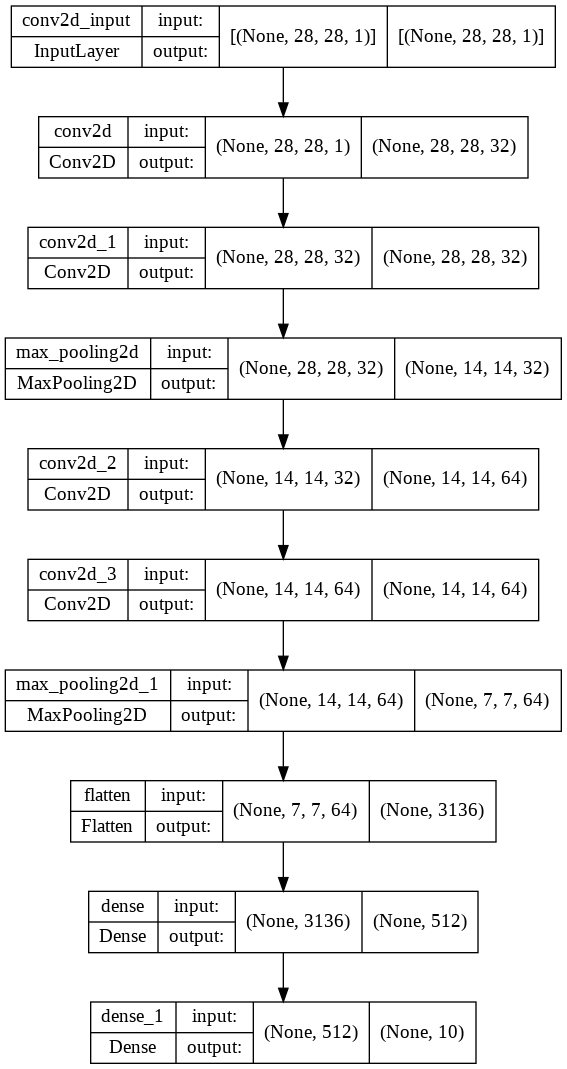

In [8]:
plot_model(model, show_shapes=True)

모델을 학습시킬 때, validation_split 옵션을 두면 훈련셋 일부를 검증셋으로 설정할 수 있습니다. 0.2로 설정할 경우, 전체 훈련셋에서 20%를 검증셋, 나머지를 훈련셋으로 구성하여 학습합니다.

콜백함수를 사용하여, 매 에포크마다 검증셋의 손실값을 체크한 후, 이전 손실값보다 낮은 경우 모델을 파일로 저장합니다. 즉 학습 종료가 되면, "best_model.h5" 파일에 저장된 모델은 손실값이 가장 낮을 때의 가중치를 가지고 있습니다.

In [9]:
checkpoint_callback = ModelCheckpoint("best_model.h5", 
                                      save_best_only=True, 
                                      monitor="val_loss")

hist = model.fit(x_train, y_train, 
                 validation_split=0.2, 
                 batch_size=32,
                 epochs=100,  
                 callbacks=[checkpoint_callback])

Epoch 1/100
1500/1500 [==============================] - 34s 16ms/step - loss: 0.3858 - accuracy: 0.8581 - val_loss: 0.2691 - val_accuracy: 0.9002
Epoch 2/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.2337 - accuracy: 0.9142 - val_loss: 0.2342 - val_accuracy: 0.9122
Epoch 3/100
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1882 - accuracy: 0.9295 - val_loss: 0.2436 - val_accuracy: 0.9085
Epoch 4/100
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1523 - accuracy: 0.9435 - val_loss: 0.2194 - val_accuracy: 0.9211
Epoch 5/100
1500/1500 [==============================] - 20s 14ms/step - loss: 0.1199 - accuracy: 0.9559 - val_loss: 0.2452 - val_accuracy: 0.9183
Epoch 6/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0879 - accuracy: 0.9679 - val_loss: 0.2384 - val_accuracy: 0.9249
Epoch 7/100
1500/1500 [==============================] - 20s 14ms/step - loss: 0.0662 - accuracy: 0.9752 - val_loss: 0

학습 시 매 에포크에 해당하는 훈련셋과 검증셋에 대한 손실값과 평가 메트릭 수치를 확인할 수 있습니다. 이를 시각화시키면 어느 에포크에서 오버피팅이 일어났는 지 한 눈에 확인할 수 있습니다.

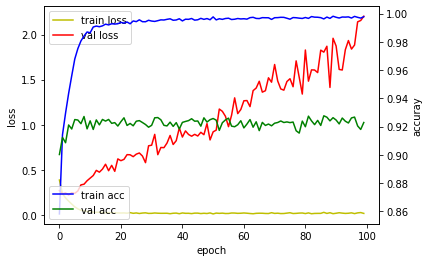

In [10]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

파일로 저장된 모델을 로딩하여 시험셋으로 최종 평가를 수행합니다.

In [11]:
model = load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

313/313 [==============================] - 2s 6ms/step - loss: 0.2390 - accuracy: 0.9160
Test accuracy 0.9160000085830688
Test loss 0.23899221420288086


또한 시험셋으로 테스트한 결과를 제출하기 위해 모델 결과 파일을 저장합니다. 출력이 10개 클래스에 해당하는 벡터이므로, 분류한 클래스 정보를 얻기 위해 가장 높은 값을 가진 인덱스 값을 가지고 옵니다. 이 인덱스가 클래스를 의미하며, 이 값을 파일로 저장합니다.

In [12]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=-1)
np.savetxt('y_pred.csv', y_pred, fmt='%d')

#### 실제로 사용해보기



In [13]:
def download_real_image(filename):
    url = 'https://github.com/aifactory-team/AFClass/blob/master/aifactory/warehouse/' + filename + '?raw=true' 
    urllib.request.urlretrieve(url, filename)

def predict_from_real_image(filename, invert):
    
    f, axarr = plt.subplots(2,2, subplot_kw={'xticks': [], 'yticks': []})
    
    img = Image.open(filename)
    axarr[0,0].imshow(img)
    axarr[0,0].set_title('orgin')

    img = img.resize((28, 28), Image.LANCZOS)
    axarr[0,1].imshow(img)
    axarr[0,1].set_title('resize')

    img = img.convert('L')
    axarr[1,0].imshow(img, cmap='gray')
    axarr[1,0].set_title('gray')

    img = np.array(img)
    if invert == True:
        img = 255.0 - img
        axarr[1,1].set_title('invert')
    else:
        axarr[1,1].set_title('no invert')
        
    axarr[1,1].imshow(img, cmap='gray')

    x_predict = img.reshape(1, 28, 28, 1).astype('float32') / 255.0
    y_predict = model.predict(x_predict)
    print(y_predict)
    print(labels[np.argmax(y_predict, axis=1)[0]])

[[7.7969272e-04 2.0238197e-06 3.4775483e-04 2.2840351e-05 1.7623190e-03
  6.9423031e-06 1.2237333e-04 3.0407946e-06 9.9690944e-01 4.3577420e-05]]
Bag


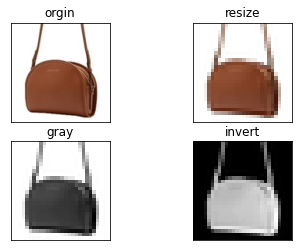

In [14]:
download_real_image('fashion_item_1.png')
predict_from_real_image('fashion_item_1.png', invert = True)    

[[9.13116673e-05 1.21236114e-08 1.38475485e-07 1.60307234e-08
  9.15595211e-10 9.15858180e-08 8.67898962e-06 1.24681662e-06
  9.99897361e-01 1.05553806e-06]]
Bag


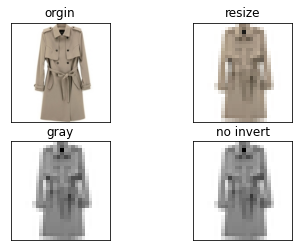

In [15]:
download_real_image('fashion_item_2.png')
predict_from_real_image('fashion_item_2.png', invert=False) 

[[1.8476084e-03 7.0554470e-06 5.8049182e-03 9.3958341e-02 8.9769542e-01
  7.4375077e-07 2.3602901e-04 2.6375546e-06 4.4426788e-04 3.0944666e-06]]
Coat


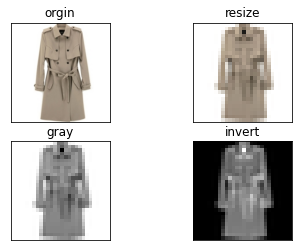

In [16]:
download_real_image('fashion_item_2.png')
predict_from_real_image('fashion_item_2.png', invert=True) 

[[2.4221526e-01 4.7710523e-04 7.6382392e-04 8.7703943e-02 5.1469854e-03
  3.1545004e-03 2.8277975e-02 7.1099461e-03 6.2469333e-01 4.5717813e-04]]
Bag


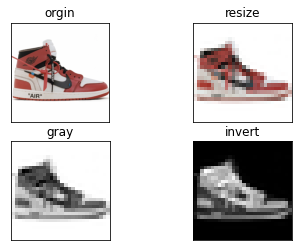

In [17]:
download_real_image('fashion_item_3.png')
predict_from_real_image('fashion_item_3.png', invert=True) 

[[3.6949019e-05 3.5899566e-06 9.8509145e-06 9.7115684e-05 1.2492689e-05
  9.1902140e-05 1.0899207e-05 9.8717427e-01 9.4689622e-06 1.2553499e-02]]
Sneaker


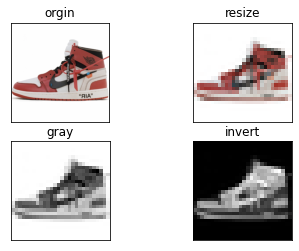

In [18]:
download_real_image('fashion_item_4.png')
predict_from_real_image('fashion_item_4.png', invert=True) 